# Exploring Indicators of Heavy Traffic on I-94 Interstate Highway

This notebook aims to identify key indicators of heavy traffic on I-94 by analyzing hourly traffic volume data from 2012 to 2018. I will explore the influence of weather, time of day, and day of the week on traffic congestion at MN DoT ATR station 301, situated between Minneapolis and St. Paul, MN. Note the station only records westbound traffic (cars moving from east to west). The dataset also includes weather features and holiday information. Results of these analyses could improve management strategies for westbound I-94 traffic.

In [27]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [28]:
# Read in file as a pandas dataframe
traffic = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

In [29]:
# Examine dataset
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [30]:
# Examine dataset
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [31]:
# Examine dataset
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [32]:
# Is there null data
traffic.isnull().sum()

holiday                0
temp                   0
rain_1h                0
snow_1h                0
clouds_all             0
weather_main           0
weather_description    0
date_time              0
traffic_volume         0
dtype: int64

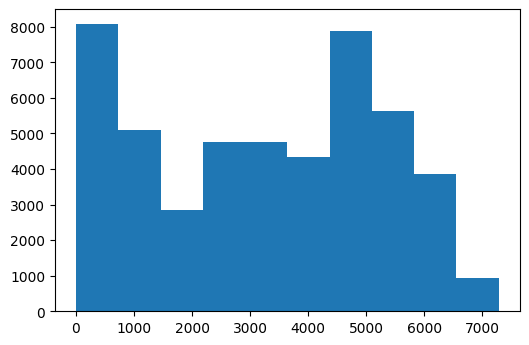

In [33]:
# Examine the distribution of the traffic_volume column
plt.hist(traffic['traffic_volume'])
plt.show()

## Traffic Volume: Day vs Night

There are two peaks in the data, possibly relating to car counts taken in during the daytime and nighttime. As such the dataset will be divided into two parts:
- Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
- Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

In [34]:
# Transform the date_time column to datetime
traffic['date_time']=pd.to_datetime(traffic['date_time'])

# Extract hour values of the date_time column
traffic_hour = traffic['date_time'].dt.hour

# Create a new column on the dataset containing the extracted hour values
traffic['traffic_hour']=traffic_hour

In [35]:
traffic['traffic_hour'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,  0,  1,
        2,  3,  4,  5,  6,  8,  7])

In [36]:
# Divide the dataset into two parts: daytime data and nighttime data
day_traffic = traffic[(traffic['traffic_hour'] >= 7) & (traffic['traffic_hour'] <= 18)]
night_traffic = traffic[(traffic['traffic_hour'] >= 19) | (traffic['traffic_hour'] <= 6)]

In [37]:
# Check the day_traffic dataset only contains daytime data
day_traffic['traffic_hour'].unique()

array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,  8,  7])

In [38]:
# Check the night_traffic dataset only contains nighttime data
night_traffic['traffic_hour'].unique()

array([19, 20, 21, 22, 23,  0,  1,  2,  3,  4,  5,  6])

In [39]:
# Find the range of the traffic volume data
night_traffic['traffic_volume'].max()-night_traffic['traffic_volume'].min()

6386

In [40]:
# Find the range of the traffic volume data
day_traffic['traffic_volume'].max()-day_traffic['traffic_volume'].min()

7280

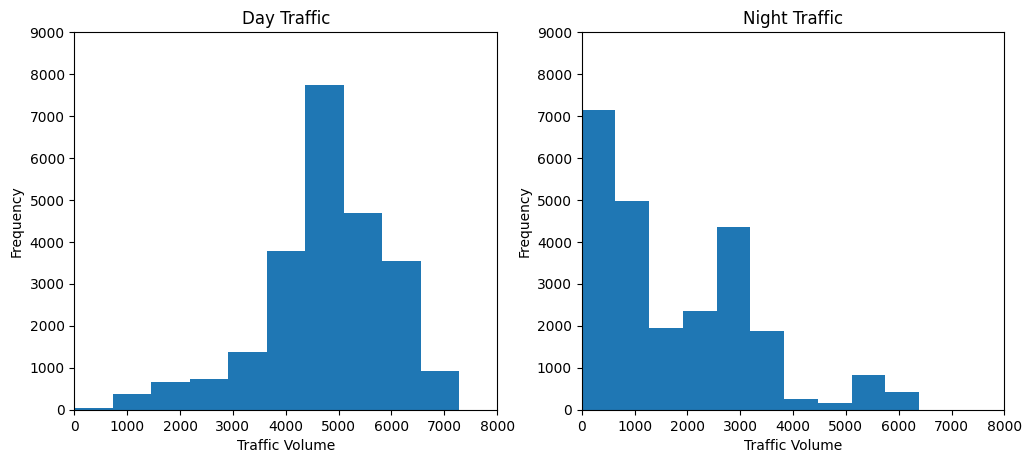

In [41]:
# Create a histogram grid for the day and night traffic
traffics = [day_traffic, night_traffic]
titles = ['Day Traffic', 'Night Traffic']

plt.figure(figsize=(12,5))

for i, traffic, title in zip(range(1,3), traffics, titles):
    plt.subplot(1,2,i)
    plt.hist(traffic['traffic_volume'])
    plt.title(title)
    plt.xlabel('Traffic Volume')
    plt.xlim([0, 8000])
    plt.ylabel('Frequency')
    plt.ylim([0, 9000])
    
plt.show()    
    

The Day Traffic histogram is shifted to the right, and as such, indicates heavy traffic. The single, tall peak indicates there is a large surge in traffic towards a certain point in the day. This peak likely corresponds to the traffic surges around 5.00, when the work day ends. 

The Night Traffic histogram is shifted to the left, indicating low traffic. This distribution shows that is not much traffic at nighttime. However, there is a peak in traffic volume that likely corresponds to the remaining traffic surges from work departures. 

Since night traffic is generally light and the goal is to find indicators of heavy traffic, I decided to focus solely on daytime traffic data moving forward.

## Time Series Analysis: Monthly
Analyse the traffic volume distribution by month to determine if certain months have exceedingly high traffic volumes.

In [42]:
# Retrieve the mean traffic volumes on a monthly basis
day_traffic['month'] = day_traffic['date_time'].dt.month
by_month = day_traffic.groupby('month').mean()
by_month

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,traffic_hour
month,,,,,,
1,265.483409,0.015080,0.000631,58.554108,4495.613727,12.386774
2,266.663789,0.004019,0.000000,51.550459,4711.198394,12.351491
3,273.619940,0.015839,0.000000,56.827811,4889.409560,12.363933
4,279.661071,0.105343,0.000000,59.221525,4906.894305,12.492278
5,289.282668,0.130863,0.000000,56.548825,4911.121609,12.478300
6,294.576068,0.271121,0.000000,48.612374,4898.019566,12.425701
7,296.785052,4.412258,0.000000,42.176619,4595.035744,12.388141
8,295.119191,0.228113,0.000000,42.556892,4928.302035,12.387604
9,292.520287,0.289807,0.000000,45.184112,4870.783145,12.401503


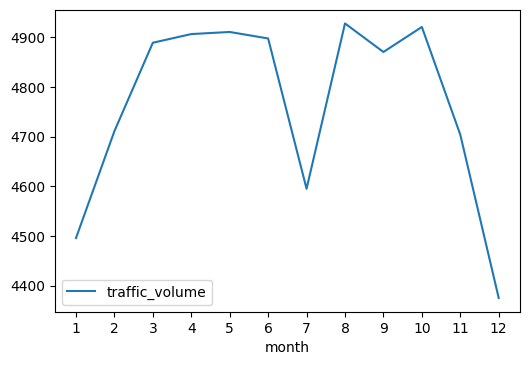

In [43]:
# Generate a line plot to visualize how the traffic volume changed each month on average.
by_month.plot(y='traffic_volume', use_index=True)
plt.xticks(range(1,13))
plt.show()

Traffic appears to be less congested during the colder months (**November to February**) and more pronounced during the warmer months (**March to October**). 

During **December and January**, the holiday season, encompassing Christmas and New Year's, frequently results in reduced commuter traffic due to individuals taking time off for family celebrations, coinciding with business closures. Simultaneously, the winter break observed in many schools and universities during these months contribute to diminished school-related traffic, coupled with families embarking on vacations during this period. Moreover, the colder weather may lead to challenging driving conditions due to snow and ice, tends to discourage long-distance travel.

However, there is a July anomaly. Is there a particular reason behind this sharp decrease in traffic volume in July? Does traffic notably decrease during **July** each year?

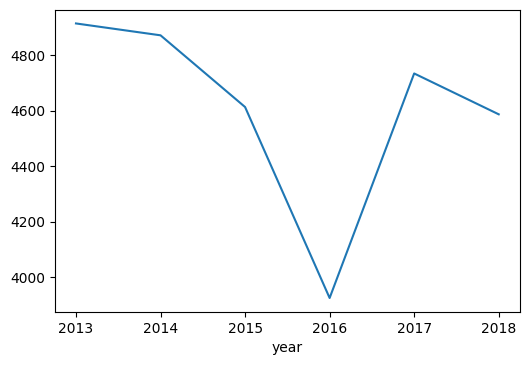

In [60]:
day_traffic['year'] = day_traffic['date_time'].dt.year
only_july = day_traffic[day_traffic['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line()
plt.show()

In most cases, July experiences heavy traffic akin to other warm months, except for a notable drop in 2016. This decline could be linked to road construction, as suggested by a 2016 article. July's prominence as a vacation month contributes to its overall reduced commuter traffic due to families utilizing the summer break for trips. Additionally, the widespread school break leads to fewer parents driving their children to school, resulting in decreased school-related traffic.

## Time Series Analysis: Day of Week
Analyse the traffic volume distribution by day of the week to determine if certain days have exceedingly high traffic volumes.

In [44]:
# Retrieve the mean traffic volumes by day of week
# 0 is Monday, 6 is Sunday
day_traffic['dayofweek'] = day_traffic['date_time'].dt.dayofweek
by_dayofweek = day_traffic.groupby('dayofweek').mean()
day_names = pd.Series(['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
by_dayofweek['day_names']=day_names
by_dayofweek

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,traffic_hour,month,day_names
dayofweek,,,,,,,,
0,282.262755,2.923823,0.000017,57.508053,4893.551286,12.472732,6.401243,Monday
1,282.301770,0.129172,0.000194,52.333234,5189.004782,12.369994,6.458757,Tuesday
2,282.198316,0.068099,0.001091,53.662119,5284.454282,12.453411,6.619158,Wednesday
3,282.279115,0.172436,0.000148,53.993191,5311.303730,12.459739,6.501184,Thursday
4,282.181216,0.092828,0.000225,51.412200,5291.600829,12.454545,6.575067,Friday
5,282.300646,0.107596,0.000094,50.446376,3927.249558,12.391573,6.498821,Saturday
6,282.280340,0.133170,0.000000,52.288699,3436.541789,12.415244,6.604179,Sunday


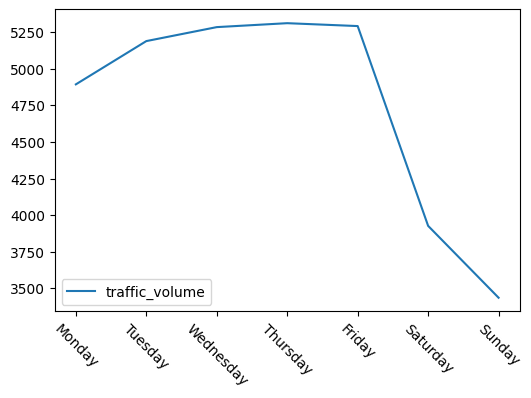

In [45]:
# Generate a line plot to visualize how the traffic volume changed each day of the week on average.
by_dayofweek.plot(x='day_names', y='traffic_volume')
plt.xlabel('')
plt.xticks(rotation = 315)
plt.show()

From the line plot above, there is significantly less traffic during the weekend, compared to business days. This is because there are fewer people commuting to offices and workplaces.

## Time Series Analysis: Hourly
Analyse the traffic volume distribution by the hour to determine if certain hours have exceedingly high traffic volumes. First seperate the business day and weekend data, since their average traffic volumes are so different.

In [46]:
# Retrieve hourly data
day_traffic['hour'] = day_traffic['date_time'].dt.hour

# Extract business days data
# Capture all data Saturday (Friday == 4)
business_days = day_traffic.copy()[day_traffic['dayofweek'] <= 4]

# Extract weekend data
# Capture all data after Friday (Saturday == 5)
weekend = day_traffic.copy()[day_traffic['dayofweek'] >= 5]

# Retrieve the mean traffic volumes by hour
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

In [47]:
by_hour_weekend

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,traffic_hour,month,dayofweek
hour,,,,,,,,
7,278.095331,0.291540,0.000000,50.006623,1589.365894,7.0,6.518212,5.501656
8,277.981017,0.083870,0.000083,48.877076,2338.578073,8.0,6.523256,5.503322
9,279.785660,0.075234,0.000364,49.688042,3111.623917,9.0,6.603120,5.492201
10,280.403811,0.079674,0.000103,48.915808,3686.632302,10.0,6.491409,5.503436
11,282.129355,0.141387,0.000000,52.372973,4044.154955,11.0,6.482883,5.491892
12,282.936119,0.095784,0.000000,51.418018,4372.482883,12.0,6.500901,5.493694
13,283.784951,0.180452,0.000000,53.095841,4362.296564,13.0,6.580470,5.497288
14,284.663261,0.087847,0.000000,52.735401,4358.543796,14.0,6.644161,5.500000
15,284.854578,0.074771,0.000000,52.148624,4342.456881,15.0,6.612844,5.506422


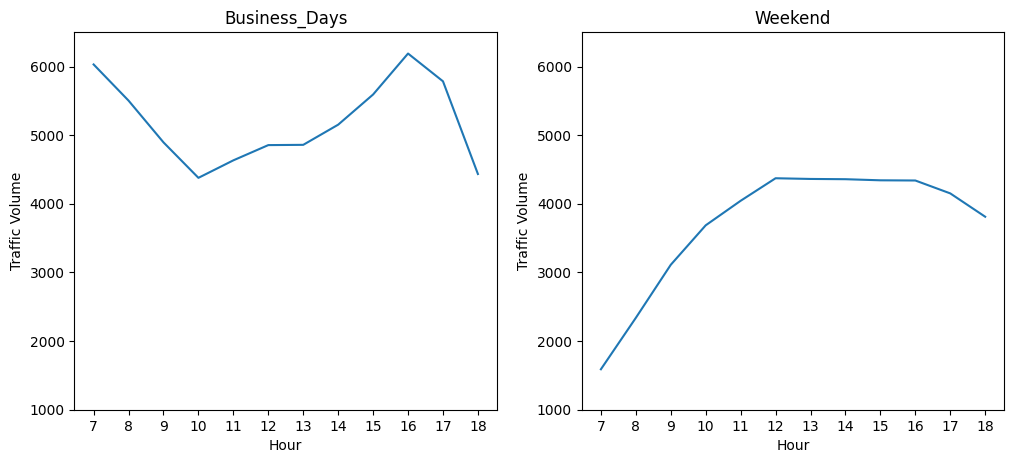

In [48]:
# Create a line grid for business_days and weekend
traffics = [by_hour_business, by_hour_weekend]
titles = ['Business_Days', 'Weekend']

plt.figure(figsize=(12,5))

for i, traffic, title in zip(range(1,3), traffics, titles):
    plt.subplot(1,2,i)
    plt.plot(traffic['traffic_volume'])
    plt.title(title)
    plt.xlabel('Hour')
    plt.xticks(range(7,19, 1))
    plt.ylim([1000, 6500])
    plt.ylabel('Traffic Volume')
    
plt.show()    


During **business days**, the traffic volume experiences a peak at 7 AM and again from 4 to 5 PM. These times align with the typical work commute hours when individuals are heading to and returning from their workplaces.

Conversely, **weekends** witness a generally reduced traffic flow due to their non-business nature. The highest traffic activity occurs between 12 PM and 6 PM. This can be attributed to people waking up later on weekends and subsequently scheduling their outings for the afternoon.

## Traffic Volume: Weather Indicators
Stepping back from the time series analyses and using the daytime dataset (day_traffic) again. Analyse weather patterns during the daytime to determine if certain types of weather correlate with exceedingly high traffic volumes.

In [49]:
# Find the correlation values between traffic_volume and the numerical weather columns.
day_traffic.corr()['traffic_volume'][['temp', 'rain_1h', 'snow_1h', 'clouds_all']]

temp          0.128317
rain_1h       0.003697
snow_1h       0.001265
clouds_all   -0.032932
Name: traffic_volume, dtype: float64

It looks like traffic volume has a small, positive correlation with temperature. No numerical weather column is a good indicator of traffic volume.

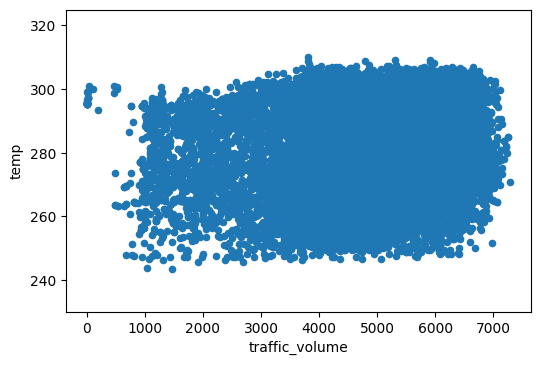

In [50]:
# Scatter plot between traffic volume and temperature
day_traffic.plot.scatter(x='traffic_volume', y='temp')
plt.ylim([230, 325]) # Note this excludes two datapoints
plt.show()

Since no numerical weather column was a good indicator of traffic volume, I'll investigate next the categorical weather-related columns: weather_main and weather_description.

In [51]:
# Aggregate the data by weather_main column 
by_weather_main = day_traffic.groupby('weather_main').mean()

# Aggregate the data by weather_description column 
by_weather_description = day_traffic.groupby('weather_description').mean()

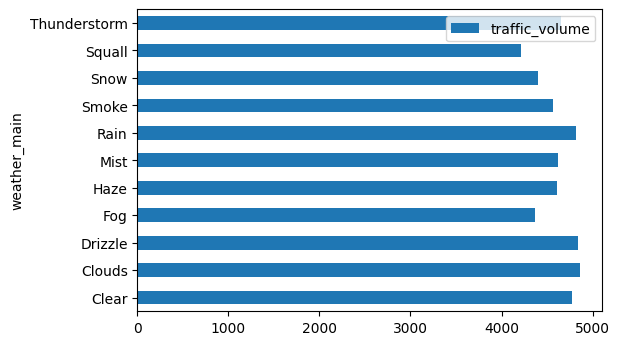

In [54]:
by_weather_main.plot.barh(y='traffic_volume', use_index=True)
plt.show()

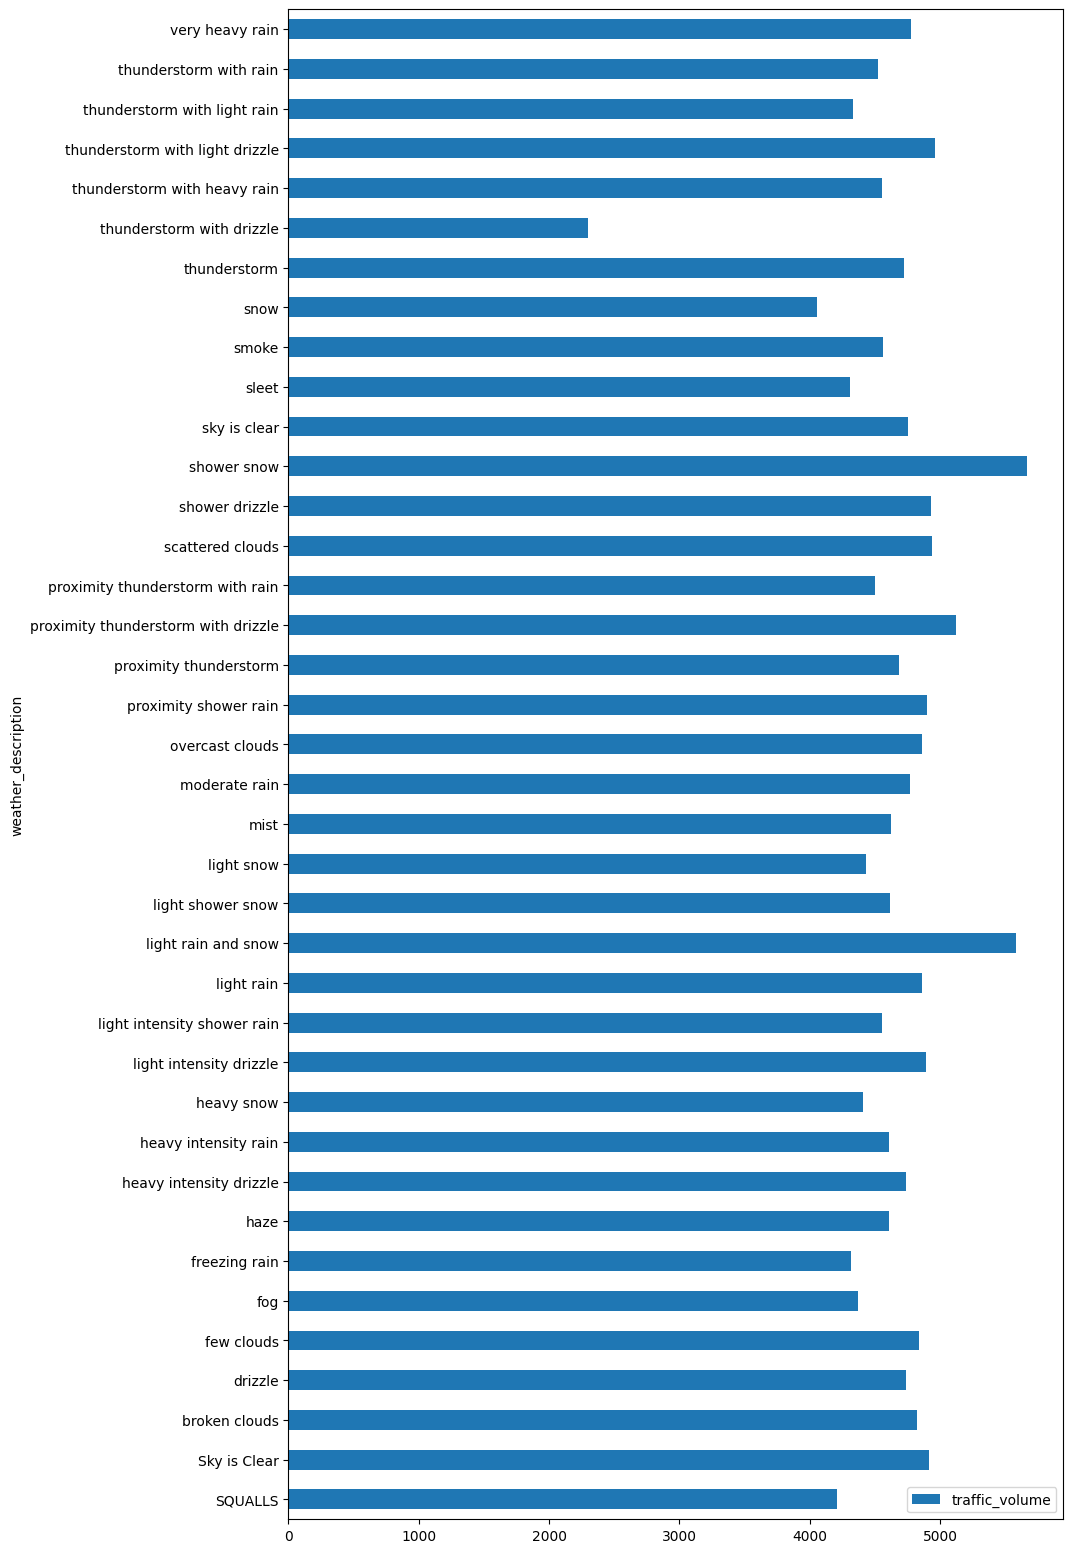

In [59]:
by_weather_description.plot.barh(y='traffic_volume', use_index=True, figsize=(10,20))
plt.show()

Heavy traffic, defined as traffic volume surpassing 5,000 cars, is noticeable during weather conditions such as **shower snow**, **light rain and snow**, and **proximity thunderstorm with drizzle**. However, when considering various weather descriptions, there seems to be no substantial variance in overall traffic volume. In summary, weather does not serve as a reliable indicator of traffic volume.

# Conclusions

The scope of this project involved an examination of various variables potentially serving as indicators for high traffic volume on the I-94 Interstate highway.

The subsequent factors emerged as robust indicators for heavy traffic:
- **School months** in contrast to school holiday months
- **Business days** versus weekends
- Peak hours: **7 AM and 4-5 PM** compared to other hours
- **Warmer months** relative to November-February

However, weather did not demonstrate a strong correlation with heavy traffic volume.